# Step-by-Step Dilation with 5×5 Kernel

This section demonstrates dilation using a **5×5 kernel** instead of 3×3.
We will:
- Define a 5×5 kernel (square or cross).
- Apply step-by-step dilation on a toy example and a real image.
- Visualize the difference compared to the smaller kernel.

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Baca gambar biner
img = cv2.imread("Image.png", 0)
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

In [4]:
# Utility: ensure binary image has values 0 or 255
def to_binary_uint8(img, thresh=127):
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
    if img.ndim == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img
    _, binary = cv2.threshold(img_gray, thresh, 255, cv2.THRESH_BINARY)
    return binary

# Utility: overlay kernel region on a grayscale image (returns RGB)
def overlay_kernel_on_image(gray, center_y, center_x, kernel):
    h, w = gray.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2
    # Make RGB
    rgb = np.stack([gray, gray, gray], axis=-1).astype(np.uint8).copy()
    y0 = center_y - pad_h
    y1 = center_y + pad_h + 1
    x0 = center_x - pad_w
    x1 = center_x + pad_w + 1
    # Clip to image bounds
    ry0, rx0 = max(0, y0), max(0, x0)
    ry1, rx1 = min(h, y1), min(w, x1)
    ky0, kx0 = ry0 - y0, rx0 - x0  # corresponding kernel start indices
    ky1, kx1 = ky0 + (ry1 - ry0), kx0 + (rx1 - rx0)
    # Color overlay (red) where kernel==1
    mask = (kernel[ky0:ky1, kx0:kx1] == 1)
    rgb[ry0:ry1, rx0:rx1][mask] = [255, 0, 0]
    return rgb


In [5]:
def manual_dilate_stepwise(binary, kernel):
    """
    Slide kernel over binary image and yield frames showing the effect.
    The binary image is 0/255. Kernel is 0/1 (uint8).
    Yields tuples: (center_y, center_x, output_before_cropped, output_after_cropped)
    """
    # Ensure proper formats
    bin_img = (binary > 127).astype(np.uint8) * 255
    k = (kernel != 0).astype(np.uint8)
    h, w = bin_img.shape
    kh, kw = k.shape
    pad_h, pad_w = kh // 2, kw // 2

    # pad input and output
    padded = np.pad(bin_img, ((pad_h, pad_h), (pad_w, pad_w)), constant_values=0)
    out = padded.copy()  # we'll update this in padded coordinates

    # iterate over all centers (padded coords)
    for y in range(pad_h, pad_h + h):
        for x in range(pad_w, pad_w + w):
            # window under kernel
            win = padded[y-pad_h:y+pad_h+1, x-pad_w:x+pad_w+1]
            before = out.copy()
            # dilation rule: if any input pixel under kernel==255 where kernel==1 => set center to 255
            if np.any((win == 255) & (k == 1)):
                out[y, x] = 255
            # yield only if changed (useful for large images)
            if before[y, x] != out[y, x]:
                # return cropped (original) images (without padding)
                out_cropped_before = before[pad_h:pad_h+h, pad_w:pad_w+w]
                out_cropped_after = out[pad_h:pad_h+h, pad_w:pad_w+w]
                center_y = y - pad_h
                center_x = x - pad_w
                yield (center_y, center_x, out_cropped_before, out_cropped_after)


Toy image (binary):


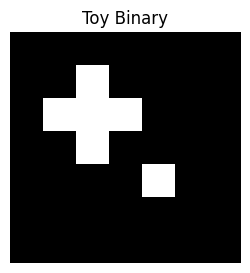

Total change steps in toy example: 12


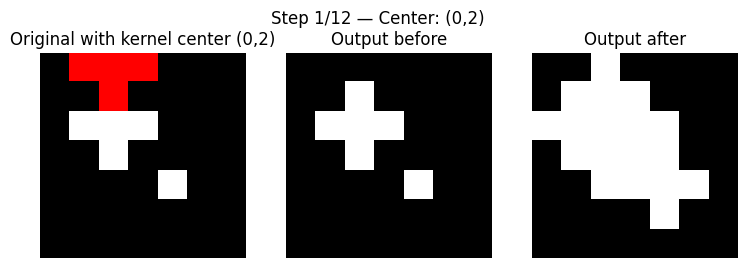

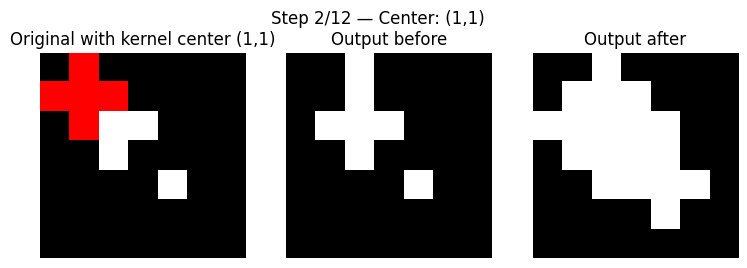

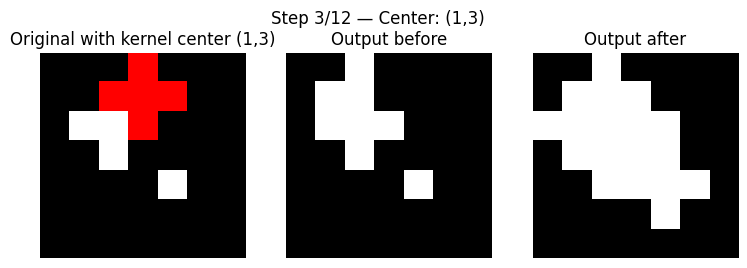

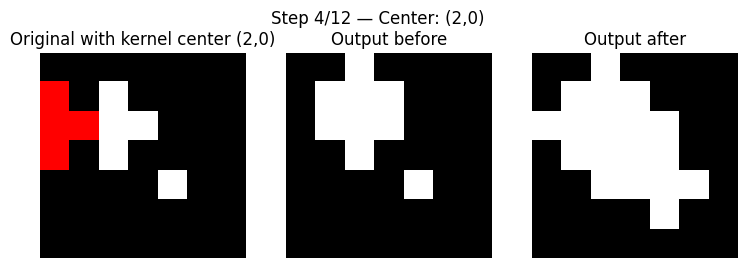

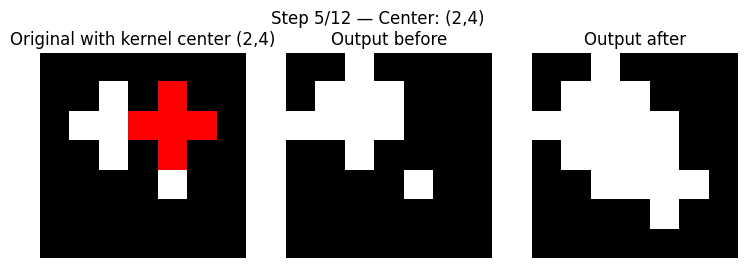

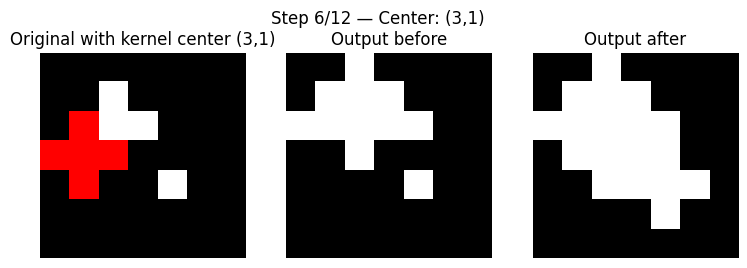

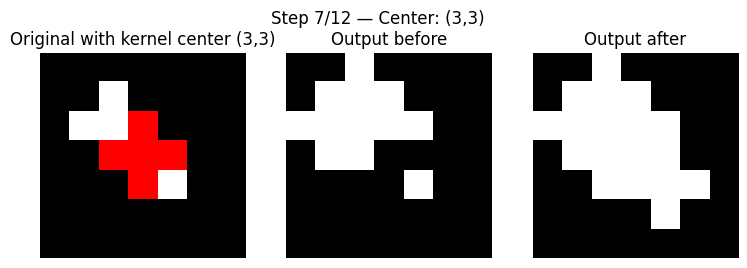

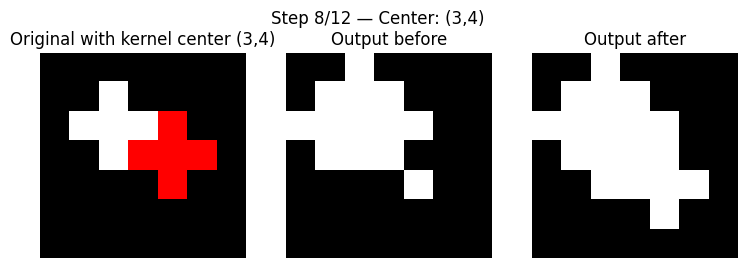

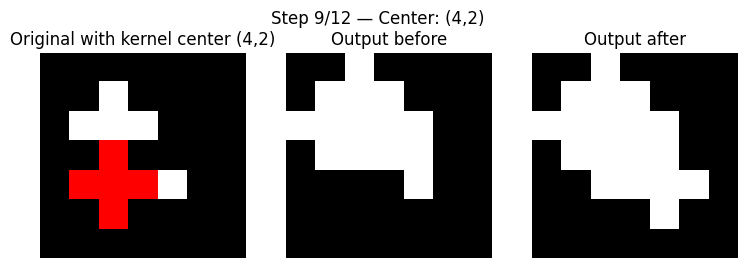

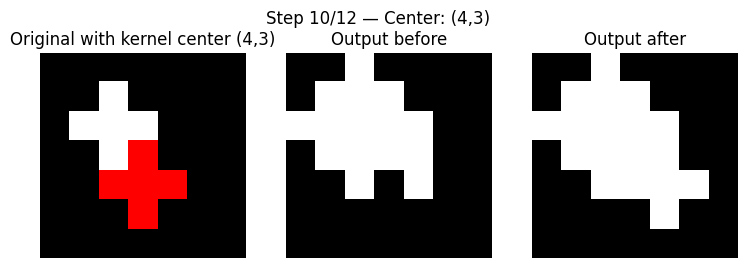

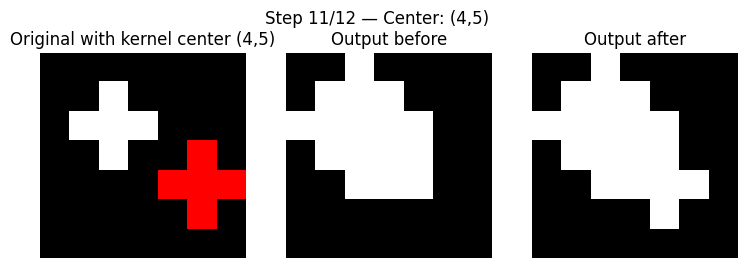

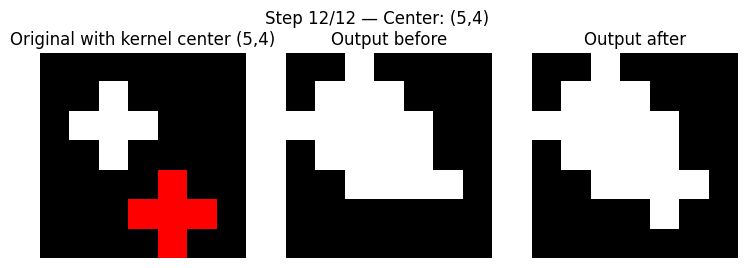

In [6]:
toy = np.array([
    [0,0,0,0,0,0,0],
    [0,0,255,0,0,0,0],
    [0,255,255,255,0,0,0],
    [0,0,255,0,0,0,0],
    [0,0,0,0,255,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0]
], dtype=np.uint8)

# cross-shaped kernel
kernel_cross = np.array([[0,1,0],
                         [1,1,1],
                         [0,1,0]], dtype=np.uint8)

binary_toy = to_binary_uint8(toy)
print("Toy image (binary):")
plt.figure(figsize=(3,3))
plt.title("Toy Binary")
plt.imshow(binary_toy, cmap='gray')
plt.axis('off')
plt.show()

# Visualize every change step-by-step (toy is small so we will see many)
frames = list(manual_dilate_stepwise(binary_toy, kernel_cross))
print(f"Total change steps in toy example: {len(frames)}")

for i, (cy, cx, before, after) in enumerate(frames):
    fig, axes = plt.subplots(1, 3, figsize=(9,3))
    # Original with kernel overlay
    axes[0].imshow(overlay_kernel_on_image(binary_toy, cy, cx, kernel_cross))
    axes[0].set_title(f"Original with kernel center ({cy},{cx})")
    axes[0].axis('off')
    # Output before applying at this center
    axes[1].imshow(before, cmap='gray')
    axes[1].set_title("Output before")
    axes[1].axis('off')
    # Output after applying at this center
    axes[2].imshow(after, cmap='gray')
    axes[2].set_title("Output after")
    axes[2].axis('off')
    plt.suptitle(f"Step {i+1}/{len(frames)} — Center: ({cy},{cx})", fontsize=12)
    plt.show()
    time.sleep(0.6)  # small pause so you can see the frame; adjust or remove as desired


 **Toy example behaviour**: since the toy image is small, the notebook will display a sequence of frames showing every time the output changes (i.e., when dilation sets a new pixel to 255).  
- You can change the sleep time or remove it to manually step through the frames.

Total added pixels (cross kernel): 1417


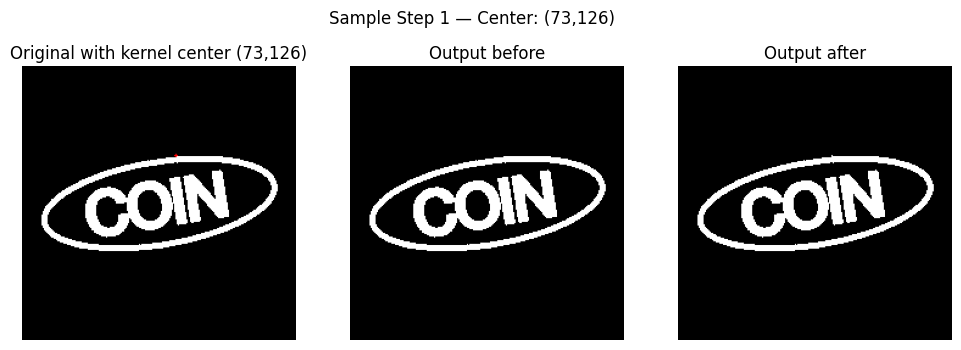

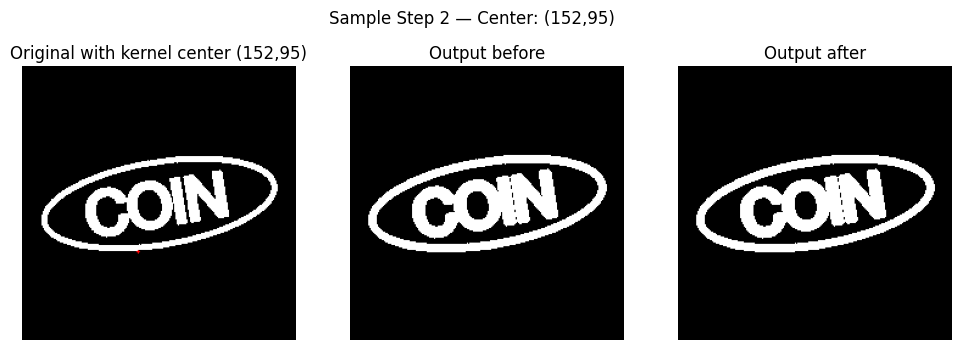

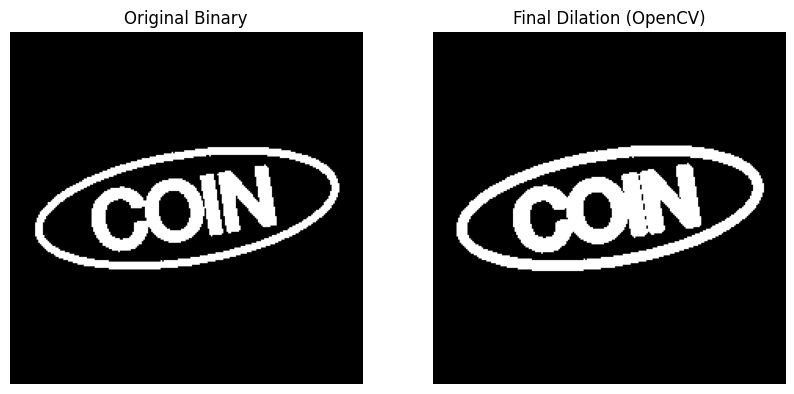

In [9]:
img = cv2.imread("Image.png")   # replace path if needed
if img is None:
    raise FileNotFoundError("lena.jpeg not found — put an image named 'lena.jpeg' in the notebook folder.")
binary_img = to_binary_uint8(img)  # 0/255

# Choose kernel (try cross vs square)
kernel_cross = np.array([[0,1,0],
                         [1,1,1],
                         [0,1,0]], dtype=np.uint8)
kernel_square = np.ones((3,3), dtype=np.uint8)

# compute final dilation quickly using OpenCV for reference
dil_cross = cv2.dilate(binary_img, kernel_cross, iterations=1)

# find positions where dilation added pixels (new white pixels)
added_positions = np.argwhere((dil_cross == 255) & (binary_img == 0))
print(f"Total added pixels (cross kernel): {len(added_positions)}")

# limit number of frames to visualize (avoid thousands)
MAX_FRAMES = 2
if len(added_positions) > MAX_FRAMES:
    # sample positions uniformly so we still see representative steps
    idxs = np.linspace(0, len(added_positions)-1, MAX_FRAMES, dtype=int)
    sample_positions = added_positions[idxs]
else:
    sample_positions = added_positions

# We'll create a manual step iterator but only show frames for positions in sample_positions
sample_set = set((int(y), int(x)) for y,x in sample_positions)

# Use the manual algorithm but only display frames for chosen centers
gen = manual_dilate_stepwise(binary_img, kernel_cross)
frames_shown = 0
for cy, cx, before, after in gen:
    if (cy, cx) in sample_set:
        fig, axes = plt.subplots(1, 3, figsize=(12,4))
        axes[0].imshow(overlay_kernel_on_image(binary_img, cy, cx, kernel_cross))
        axes[0].set_title(f"Original with kernel center ({cy},{cx})")
        axes[0].axis('off')
        axes[1].imshow(before, cmap='gray')
        axes[1].set_title("Output before")
        axes[1].axis('off')
        axes[2].imshow(after, cmap='gray')
        axes[2].set_title("Output after")
        axes[2].axis('off')
        plt.suptitle(f"Sample Step {frames_shown+1} — Center: ({cy},{cx})", fontsize=12)
        plt.show()
        frames_shown += 1
        time.sleep(0.45)
        if frames_shown >= len(sample_positions):
            break

# Show final result vs original
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(binary_img, cmap='gray')
axes[0].set_title("Original Binary")
axes[0].axis('off')
axes[1].imshow(dil_cross, cmap='gray')
axes[1].set_title("Final Dilation (OpenCV)")
axes[1].axis('off')
plt.show()


🔎 Explanation

- 5×5 Square kernel expands a white pixel in all directions within a 5×5 block.
- 5×5 Cross kernel expands pixels along a cross pattern (vertical + horizontal arms).
- The larger kernel results in thicker object boundaries compared to the 3×3 kernel.